Selamat datang di laman saya, berikut ini adalah Proyek Analisis Sentimental yang dibuat untuk memenuhi penugasan 'Belajar Pengembangan Machine Learning'.

Dataset yang saya ambil adalah, dataset yang berisikan Review dari aplikasi mybca di playstore. Dataset di scrapping dengan menggunakan modul google-play-scraper. Setelah proses scrapping, dataset hanya diambil kolom review.

Tujuan dari Proyek ini adalah untuk mencari spesimen nilai review positif, negatif, dan neutral. Proses proyek meliputi preprosessing, ekstraksi data, pemodelan, dan evaluasi.

Model yang saya uji adalah:
1. Logistic Regression (N-gram + 70/30)
2. Support Vector Machine (BoW + 80/20)
3. Deep Neural Network (TF-IDF + 80/20)

# **Import Library**

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
seed = 0
np.random.seed(seed)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

import datetime as dt
import re
import string  # Berisi konstanta string, seperti tanda baca
from nltk.tokenize import word_tokenize  # Tokenisasi teks
from nltk.corpus import stopwords  # Daftar kata-kata berhenti dalam teks

!pip install sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from wordcloud import WordCloud

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# **Loading Dataset**

In [2]:
app_reviews_df = pd.read_csv('ulasan_mybca.csv')
app_reviews_df.head()

,Review
0,setelah update...saat buka icon semua menu..la...
1,"Cukup kecewa. Tanpa info yang jelas, saldo lan..."
2,"Saran pengembangan, tolong kembangin lagi buat..."
3,"Setiap saya login selalu salah,, padahal baru ..."
4,"aplikasi terlalu repot, kebanyakan aplikasi. a..."


In [3]:
app_reviews_df.shape

(20076, 1)

In [4]:
# Menghitung jumlah baris dan kolom dalam DataFrame
jumlah_ulasan, jumlah_kolom = app_reviews_df.shape

In [5]:
# Menampilkan lima baris pertama dari DataFrame app_reviews_df
app_reviews_df.head()

,Review
0,setelah update...saat buka icon semua menu..la...
1,"Cukup kecewa. Tanpa info yang jelas, saldo lan..."
2,"Saran pengembangan, tolong kembangin lagi buat..."
3,"Setiap saya login selalu salah,, padahal baru ..."
4,"aplikasi terlalu repot, kebanyakan aplikasi. a..."


In [6]:
# Menampilkan informasi tentang DataFrame app_reviews_df
app_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20076 entries, 0 to 20075
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20076 non-null  object
dtypes: object(1)
memory usage: 157.0+ KB


In [7]:
# Membuat DataFrame baru (clean_df) dengan menghapus baris yang memiliki nilai yang hilang (NaN) dari app_reviews_df
clean_df = app_reviews_df.dropna()

In [8]:
# Menghapus baris duplikat dari DataFrame clean_df
clean_df = clean_df.drop_duplicates()

# Menghitung jumlah baris dan kolom dalam DataFrame clean_df setelah menghapus duplikat
jumlah_ulasan_setelah_hapus_duplikat, jumlah_kolom_setelah_hapus_duplikat = clean_df.shape

In [9]:
jumlah_ulasan_setelah_hapus_duplikat, jumlah_kolom_setelah_hapus_duplikat

(16903, 1)

In [10]:
clean_df.shape

(16903, 1)

In [11]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # menghapus mention
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # menghapus hashtag
    text = re.sub(r'RT[\s]', '', text) # menghapus RT
    text = re.sub(r"http\S+", '', text) # menghapus link
    text = re.sub(r'[0-9]+', '', text) # menghapus angka
    text = re.sub(r'[^\w\s]', '', text) # menghapus karakter selain huruf dan angka

    text = text.replace('\n', ' ') # mengganti baris baru dengan spasi
    text = text.translate(str.maketrans('', '', string.punctuation)) # menghapus semua tanda baca
    text = text.strip(' ') # menghapus karakter spasi dari kiri dan kanan teks
    return text

def casefoldingText(text): # Mengubah semua karakter dalam teks menjadi huruf kecil
    text = text.lower()
    return text

def tokenizingText(text): # Memecah atau membagi string, teks menjadi daftar token
    text = word_tokenize(text)
    return text

def filteringText(text): # Menghapus stopwords dalam teks
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

def stemmingText(text): # Mengurangi kata ke bentuk dasarnya yang menghilangkan imbuhan awalan dan akhiran atau ke akar kata
    # Membuat objek stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    # Memecah teks menjadi daftar kata
    words = text.split()

    # Menerapkan stemming pada setiap kata dalam daftar
    stemmed_words = [stemmer.stem(word) for word in words]

    # Menggabungkan kata-kata yang telah distem
    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

def toSentence(list_words): # Mengubah daftar kata menjadi kalimat
    sentence = ' '.join(word for word in list_words)
    return sentence

In [12]:
slangwords = {"@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar", "bgt": "banget", "maks": "maksimal"}
def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [13]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
clean_df['text_clean'] = clean_df['Review'].apply(cleaningText)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
clean_df['text_casefoldingText'] = clean_df['text_clean'].apply(casefoldingText)

# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
clean_df['text_slangwords'] = clean_df['text_casefoldingText'].apply(fix_slangwords)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
clean_df['text_tokenizingText'] = clean_df['text_slangwords'].apply(tokenizingText)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
clean_df['text_stopword'] = clean_df['text_tokenizingText'].apply(filteringText)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
clean_df['text_akhir'] = clean_df['text_stopword'].apply(toSentence)

# **Pelabelan**

In [14]:
import csv
import requests
from io import StringIO

# Membaca data kamus kata-kata positif dari GitHub
lexicon_positive = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub

if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma

    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_positive[row[0]] = int(row[1])
        # Menambahkan kata-kata positif dan skornya ke dalam kamus lexicon_positive
else:
    print("Failed to fetch positive lexicon data")

# Membaca data kamus kata-kata negatif dari GitHub
lexicon_negative = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub

if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma

    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_negative[row[0]] = int(row[1])
        # Menambahkan kata-kata negatif dan skornya dalam kamus lexicon_negative
else:
    print("Failed to fetch negative lexicon data")

In [15]:
# Fungsi untuk menentukan polaritas sentimen dari tweet

def sentiment_analysis_lexicon_indonesia(text):
    #for word in text:

    score = 0
    # Inisialisasi skor sentimen ke 0

    for word in text:
        # Mengulangi setiap kata dalam teks

        if (word in lexicon_positive):
            score = score + lexicon_positive[word]
            # Jika kata ada dalam kamus positif, tambahkan skornya ke skor sentimen

    for word in text:
        # Mengulangi setiap kata dalam teks (sekali lagi)

        if (word in lexicon_negative):
            score = score + lexicon_negative[word]
            # Jika kata ada dalam kamus negatif, kurangkan skornya dari skor sentimen

    polarity=''
    # Inisialisasi variabel polaritas

    if score > 0:
        polarity = 'positive'
    elif score < 0:
        polarity = 'negative'
    else:
        polarity = 'neutral'

    return score, polarity

In [16]:
results = clean_df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
clean_df['polarity_score'] = results[0]
clean_df['polarity'] = results[1]
print(clean_df['polarity'].value_counts())

polarity
negative    8876
positive    4988
neutral     3039
Name: count, dtype: int64


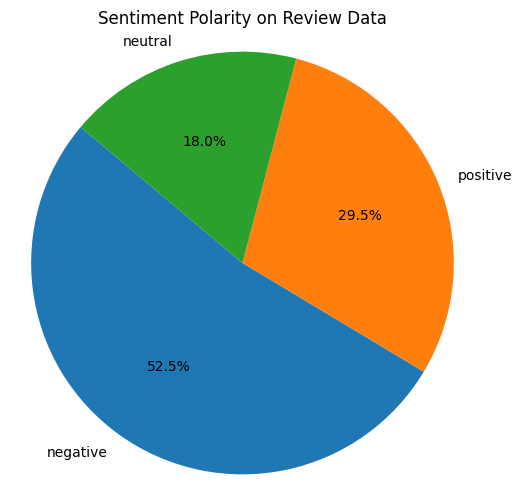

In [17]:
# Hitung jumlah masing-masing polaritas
polarity_counts = clean_df['polarity'].value_counts()

# Buat pie chart
plt.figure(figsize=(6,6))
plt.pie(polarity_counts, labels=polarity_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Polarity on Review Data')
plt.axis('equal')
plt.show()


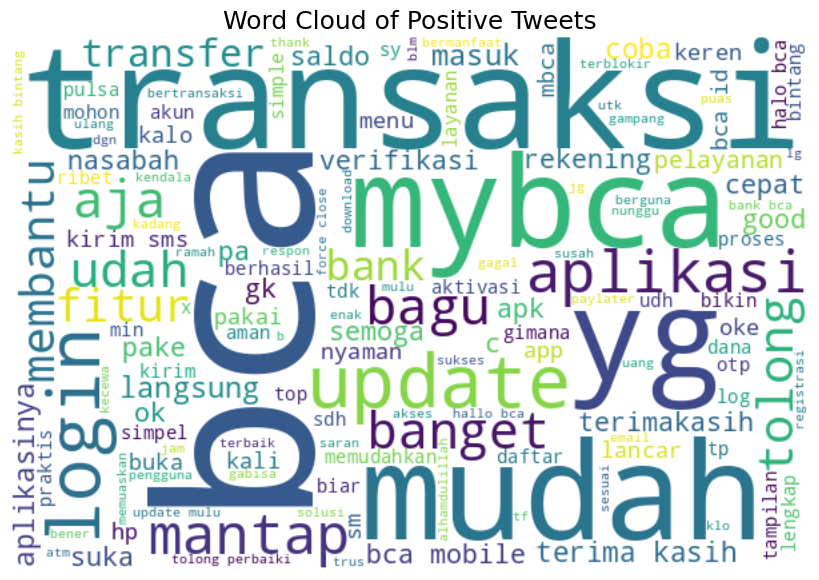

In [18]:
# Mengatur tampilan Pandas agar bisa menampilkan teks panjang
pd.set_option('display.max_colwidth', 3000)

# Filter tweet dengan polaritas positif
positive_tweets = clean_df[clean_df['polarity'] == 'positive'][['text_akhir', 'polarity_score', 'polarity', 'text_stopword']]
positive_tweets = positive_tweets.sort_values(by='polarity_score', ascending=False).reset_index(drop=True)
positive_tweets.index += 1  # Mulai index dari 1 agar lebih rapi

# Gabungkan semua kata dalam tweet positif (asumsinya text_stopword sudah berupa list of tokens)
list_words_positive = ' '.join(word for tweet in positive_tweets['text_stopword'] for word in tweet)

# Buat WordCloud
wordcloud_positive = WordCloud(
    width=600,
    height=400,
    background_color='white',
    min_font_size=10
).generate(list_words_positive)

# Tampilkan WordCloud
plt.figure(figsize=(8, 6))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Word Cloud of Positive Tweets', fontsize=18)
plt.axis('off')  # Hilangkan sumbu
plt.tight_layout(pad=0)
plt.show()

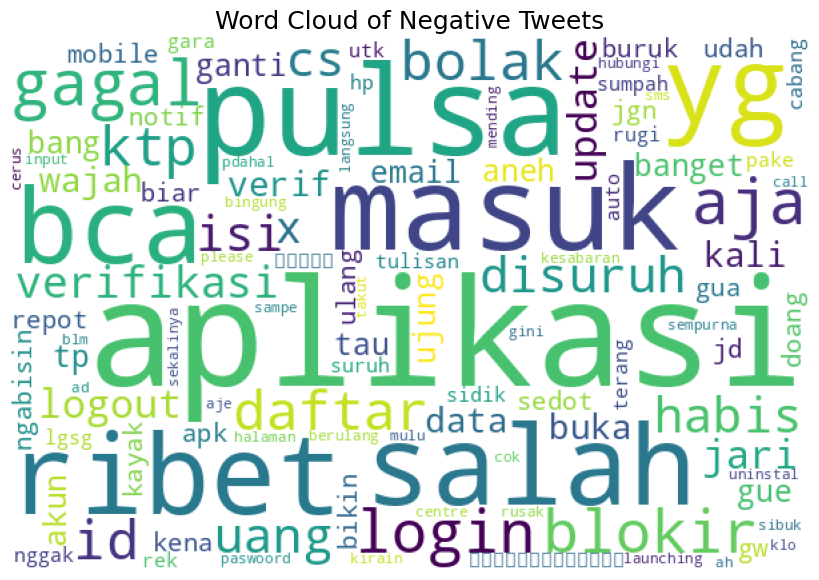

In [19]:
# Mengatur tampilan Pandas
pd.set_option('display.max_colwidth', 3000)

# Filter tweet negatif
negative_tweets = clean_df[clean_df['polarity'] == 'negative'][['text_akhir', 'polarity_score', 'polarity', 'text_stopword']]
negative_tweets = negative_tweets.sort_values(by='polarity_score', ascending=True).head(10).reset_index(drop=True)
negative_tweets.index += 1

# Kumpulkan semua kata dalam tweet negatif
list_words_negative = ' '.join(word for tweet in negative_tweets['text_stopword'] for word in tweet)

# Membuat WordCloud untuk tweet negatif
wordcloud_negative = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words_negative)

# Tampilkan WordCloud
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud of Negative Tweets', fontsize=18)
ax.imshow(wordcloud_negative)
ax.axis('off')
ax.grid(False)
plt.tight_layout(pad=0)
plt.show()

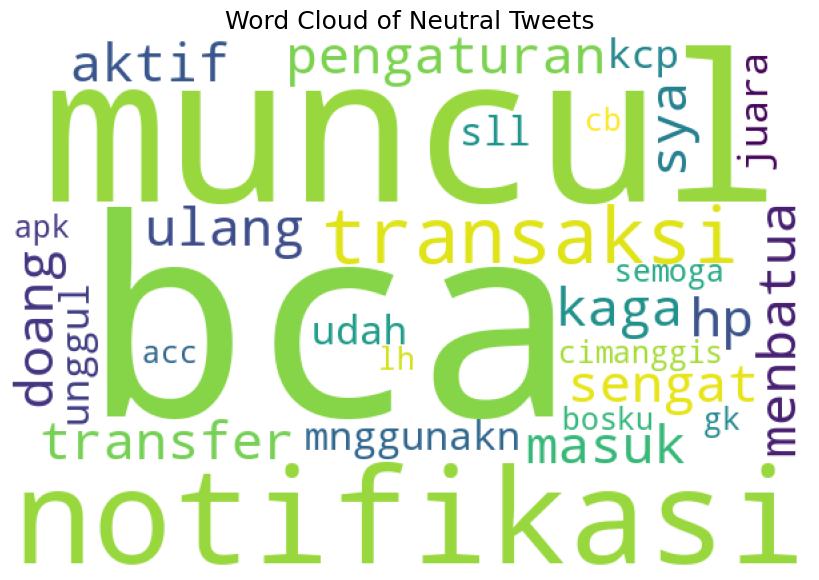

In [20]:
# Mengatur tampilan Pandas
pd.set_option('display.max_colwidth', 3000)

# Filter tweet netral
neutral_tweets = clean_df[clean_df['polarity'] == 'neutral'][['text_akhir', 'polarity_score', 'polarity', 'text_stopword']]
neutral_tweets = neutral_tweets.sort_values(by='polarity_score', ascending=True).head(10).reset_index(drop=True)
neutral_tweets.index += 1

# Kumpulkan semua kata dalam tweet netral
list_words_neutral = ' '.join(word for tweet in neutral_tweets['text_stopword'] for word in tweet)

# Membuat WordCloud untuk tweet netral
wordcloud_neutral = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words_neutral)

# Tampilkan WordCloud
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud of Neutral Tweets', fontsize=18)
ax.imshow(wordcloud_neutral)
ax.axis('off')
ax.grid(False)
plt.tight_layout(pad=0)
plt.show()

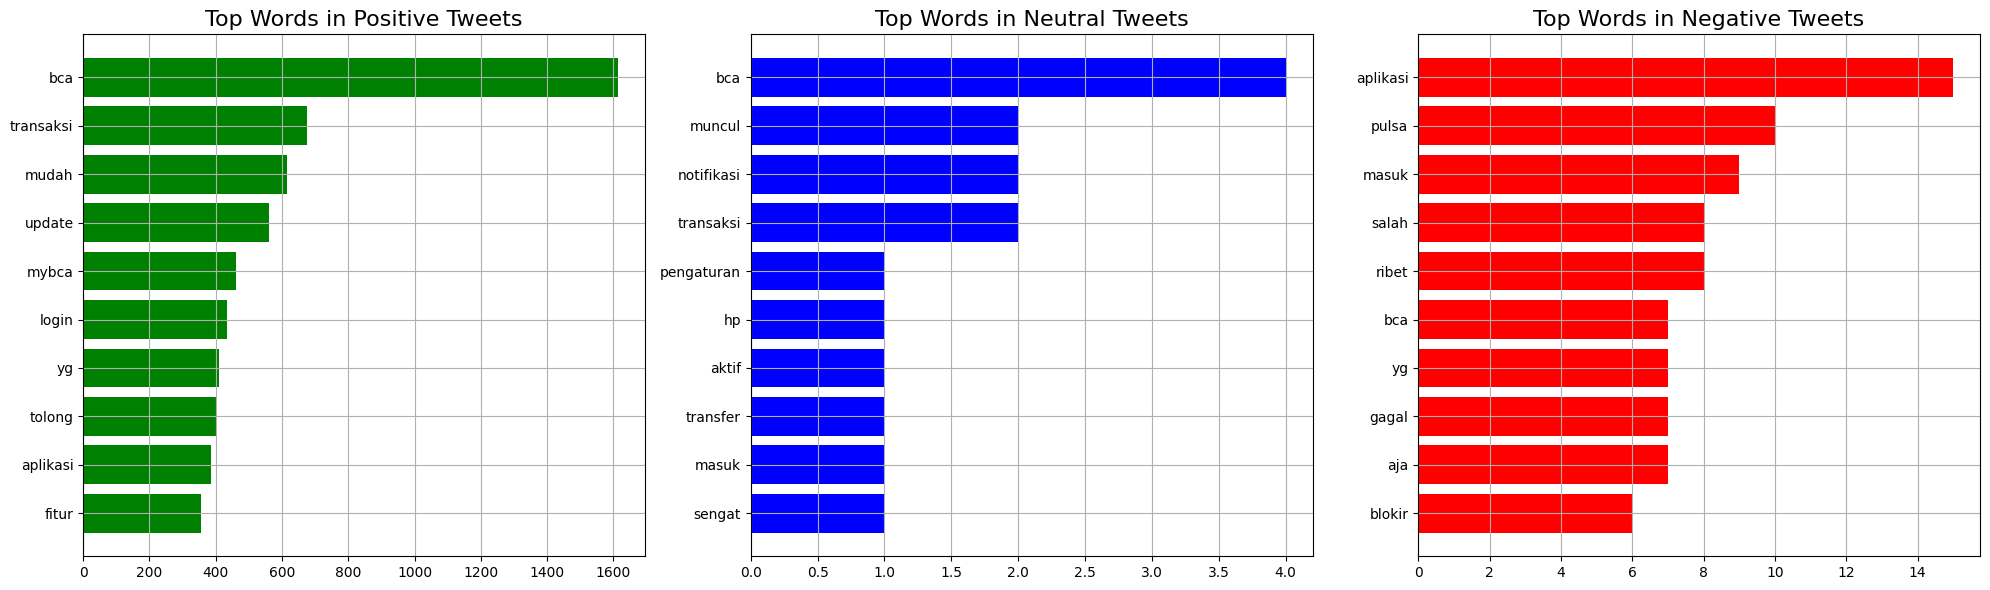

In [21]:
from collections import Counter

# Fungsi untuk menghitung kata dan membuat grafik batang
def plot_top_words(df_subset, title, ax, color):
    list_words = []
    for tweet in df_subset['text_stopword']:
        list_words.extend(tweet)

    # menghitung frekuensi kata
    word_counts = Counter(list_words)

    # mengambil 10 kata teratas
    most_common_words = word_counts.most_common(10)
    words, counts = zip(*most_common_words)

    # membuat grafik batang
    ax.barh(words, counts, color=color)
    ax.set_title(title, fontsize=16)
    ax.invert_yaxis()  # Supaya kata paling sering ada di atas
    ax.grid(True)

# membuat figure dengan 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Grafik batang untuk masing-masing polaritas
plot_top_words(positive_tweets, 'Top Words in Positive Tweets', axes[0], color='green')
plot_top_words(neutral_tweets, 'Top Words in Neutral Tweets', axes[1], color='blue')
plot_top_words(negative_tweets, 'Top Words in Negative Tweets', axes[2], color='red')

# merapihkan layout
plt.tight_layout()
plt.show()


# **Data Splitting & Modelling**

In [22]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import Callback
from keras.layers import Dense, Dropout

In [23]:
le = LabelEncoder()

y = clean_df['polarity']
y = le.fit_transform(clean_df['polarity'])

In [24]:
# Ekstraksi Fitur dengan ngram
ngram = CountVectorizer(ngram_range=(1, 3), max_features=1000)
X_ngram = ngram.fit_transform(clean_df['text_akhir'])

# Split data (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X_ngram, y, test_size=0.3, random_state=42)

# Model klasifikasi
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

# Prediksi dan evaluasi
y_pred = model_lr.predict(X_test)
print("Skema 1 - Logistic Regression (N-gram + 70/30):")
print(classification_report(y_test, y_pred))


Skema 1 - Logistic Regression (N-gram + 70/30):
              precision    recall  f1-score   support

           0       0.92      0.91      0.92      2689
           1       0.71      0.81      0.76       905
           2       0.88      0.83      0.85      1477

    accuracy                           0.87      5071
   macro avg       0.84      0.85      0.84      5071
weighted avg       0.87      0.87      0.87      5071



In [25]:
# Ekstraksi Fitur dengan Bag of Words
bow = CountVectorizer(max_features=1000)
X_bow = bow.fit_transform(clean_df['text_akhir'])

# Split 80% train / 20% test
X_train, X_test, y_train, y_test = train_test_split(X_bow, y, test_size=0.2, random_state=42)

# Model: SVM (LinearSVC)
model_svm = LinearSVC()
model_svm.fit(X_train, y_train)

# Evaluasi
y_pred = model_svm.predict(X_test)
print("Skema 2 - SVM (BoW + 80/20):")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Skema 2 - SVM (BoW + 80/20):
              precision    recall  f1-score   support

    negative       0.94      0.93      0.94      1787
     neutral       0.77      0.82      0.79       610
    positive       0.88      0.87      0.88       984

    accuracy                           0.89      3381
   macro avg       0.86      0.87      0.87      3381
weighted avg       0.89      0.89      0.89      3381



In [26]:
# Label encoding
label_encoder = LabelEncoder()
clean_df['label'] = label_encoder.fit_transform(clean_df['polarity'])
y = to_categorical(clean_df['label'])

# TF-IDF vektor dari text_akhir
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(clean_df['text_akhir']).toarray()

# Split data 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# === Custom Callback: hentikan training saat akurasi > 95% ===
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.96:
            print("\nAkurasi telah mencapai > 95%! Training dihentikan.")
            self.model.stop_training = True

callbacks = myCallback()

# Bangun model DNN
model = Sequential([
    Dense(128, activation='relu', input_shape=(X.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training model dengan callback
model.fit(
    X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test), callbacks=[callbacks], verbose=2
)

# Evaluasi hasil
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nSkema 3 - Deep Neural Network (TF-IDF + 80/20):")
print(f"Akurasi DNN (Train): {train_acc:.4f}")
print(f"Akurasi DNN (Test) : {test_acc:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
423/423 - 8s - 19ms/step - accuracy: 0.7249 - loss: 0.6264 - val_accuracy: 0.8909 - val_loss: 0.3381
Epoch 2/5
423/423 - 5s - 11ms/step - accuracy: 0.9117 - loss: 0.2606 - val_accuracy: 0.8903 - val_loss: 0.2955
Epoch 3/5
423/423 - 4s - 9ms/step - accuracy: 0.9446 - loss: 0.1636 - val_accuracy: 0.8988 - val_loss: 0.2770
Epoch 4/5

Akurasi telah mencapai > 95%! Training dihentikan.
423/423 - 6s - 14ms/step - accuracy: 0.9645 - loss: 0.1090 - val_accuracy: 0.9006 - val_loss: 0.3024

Skema 3 - Deep Neural Network (TF-IDF + 80/20):
Akurasi DNN (Train): 0.9844
Akurasi DNN (Test) : 0.9006


In [28]:
pip freeze requirements.txt

absl-py==1.4.0
accelerate==1.5.2
aiohappyeyeballs==2.6.1
aiohttp==3.11.15
aiosignal==1.3.2
alabaster==1.0.0
albucore==0.0.23
albumentations==2.0.5
ale-py==0.10.2
altair==5.5.0
annotated-types==0.7.0
anyio==4.9.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.7.1
arviz==0.21.0
astropy==7.0.1
astropy-iers-data==0.2025.4.7.0.35.30
astunparse==1.6.3
atpublic==5.1
attrs==25.3.0
audioread==3.0.1
autograd==1.7.0
babel==2.17.0
backcall==0.2.0
backports.tarfile==1.2.0
beautifulsoup4==4.13.3
betterproto==2.0.0b6
bigframes==1.42.0
bigquery-magics==0.9.0
bleach==6.2.0
blinker==1.9.0
blis==1.3.0
blosc2==3.3.0
bokeh==3.6.3
Bottleneck==1.4.2
bqplot==0.12.44
branca==0.8.1
CacheControl==0.14.2
cachetools==5.5.2
catalogue==2.0.10
certifi==2025.1.31
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.1
chex==0.1.89
clarabel==0.10.0
click==8.1.8
cloudpathlib==0.21.0
cloudpickle==3.1.1
cmake==3.31.6
cmdstanpy==1.2.5
colorcet==3.1.0
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confec